In [1]:
import pyterrier as pt
import pandas as pd
from LLmsfJiT import read_trec_queries
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

/home/vscode/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pt.init()

PyTerrier 0.10.0 has loaded Terrier 5.8 (built by craigm on 2023-11-01 18:05) and terrier-helper 0.0.8

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


In [3]:
def remap_to_bin(row: pd.core.series.Series):
    if row.label == 2:
        return 1
    else:
        return row.label

In [4]:
topics = pd.DataFrame(list(read_trec_queries("../rel_files/queries.txt").items()), columns=["qid", "query"])
topics["qid"] = topics["qid"].astype(str)

qrels = pd.read_csv("../rel_files/rel_table_qrels.txt", delimiter="\t", names=["qid", "iteration", "docno", "label"]).drop(columns=["iteration"])
qrels["qid"] = qrels["qid"].astype(str)
qrels["label"] = qrels["label"].astype(int)
qrels["label"] = qrels.apply(remap_to_bin, axis=1)

qrels_gpt = pd.read_csv("../gpt_judgements/rel_table_qrels.txt", delimiter="\t", names=["qid", "iteration", "docno", "label"]).drop(columns=["iteration"])
qrels_gpt["qid"] = qrels_gpt["qid"].astype(str)
qrels_gpt["label"] = qrels_gpt["label"].astype(int)
qrels_gpt["label"] = qrels_gpt.apply(remap_to_bin, axis=1)


In [5]:
def generate_experiments_from_index(index_path, topics, qrels):

    index = pt.IndexFactory.of(index_path)
    # tf_idf = pt.BatchRetrieve(index, wmodel="TF_IDF")
    # bm25 = pt.BatchRetrieve(index, wmodel="BM25")
    # DLM = pt.BatchRetrieve(index, wmodel="DirichletLM")
    # pl2 = pt.BatchRetrieve(index, wmodel="PL2")

    retrievers = []
    for wmodel in ["TF_IDF", "BM25", "DirichletLM", "PL2", "CoordinateMatch", "DFIC", "DFIZ", "DFR_BM25", "DFRee", "DFReeKLIM",
                   "Dl", "DLH", "DLH13", "DPH", "Hiemstra_LM", "IFB2", "In_expB2", "In_expC2", "InB2", "InL2", "Js_KLs", "LemurTF_IDF", 
                   "LGD", "Tf"]:
        retrievers.append(pt.BatchRetrieve(index, wmodel=wmodel))

    experiments = []
    for x in range(topics["qid"].nunique()):
        ex = pt.Experiment(retrievers, topics.iloc[x].to_frame().T, qrels, eval_metrics=["map", "P_5", "P_10",  "ndcg_cut_5", "ndcg_cut_10"])
        experiments.append(ex)
    experiment_df = pd.concat(experiments)
    models = experiment_df["name"].unique()

    index_ls = []
    for q in topics["qid"]:
        index_ls.extend(list(zip(itertools.repeat(q), models) ))

    index = pd.MultiIndex.from_tuples(index_ls, names=["qid", "model"])
    experiment_df.index = index

    experiment_df.drop(columns=["name"], inplace=True)
    return experiment_df

In [6]:
ex_human = generate_experiments_from_index("../pyterrier_indexes/single_field_index/data.properties", topics, qrels)

In [7]:
ex_gpt = generate_experiments_from_index("../pyterrier_indexes/single_field_index/data.properties", topics, qrels_gpt)

In [8]:
human_map = ex_human.groupby("model", as_index=True).map.mean()
gpt_map = ex_gpt.groupby("model", as_index=True).map.mean()

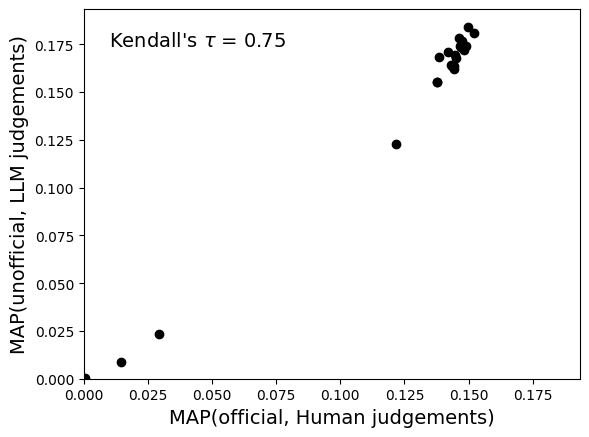

In [9]:
kt = round(kendalltau(human_map, gpt_map).statistic, 2)
plt.scatter(human_map, gpt_map, color="black")

max_lim = max(plt.xlim()[1], plt.ylim()[1])
plt.text(max_lim/20, max_lim - max_lim/10, f"Kendall's $\\tau$ = {kt}", fontdict={"size": 14})
plt.xlim(0, max_lim)
plt.ylim(0, max_lim)
plt.ylabel("MAP(unofficial, LLM judgements)", size=14)
plt.xlabel("MAP(official, Human judgements)", size=14)
plt.savefig("map.pdf", transparent=True)
plt.show()

In [10]:
human_ndcg = ex_human.groupby("model", as_index=True).ndcg_cut_10.mean()
gpt_ndcg = ex_gpt.groupby("model", as_index=True).ndcg_cut_10.mean()

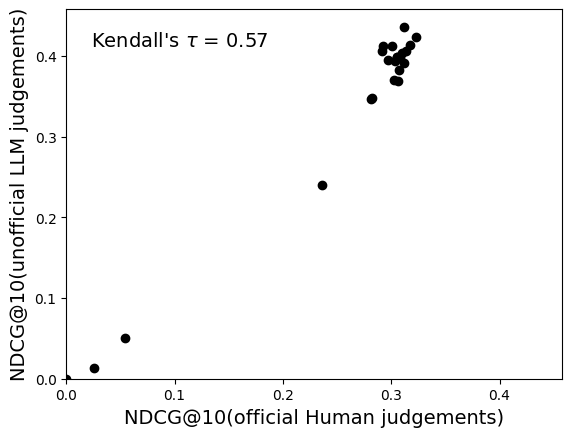

SignificanceResult(statistic=0.5652173913043478, pvalue=5.039225984314531e-05)


In [11]:
kt = kendalltau(human_ndcg, gpt_ndcg)
plt.scatter(human_ndcg, gpt_ndcg, color="black")
max_lim = max(plt.xlim()[1], plt.ylim()[1])
plt.xlim(0, max_lim)
plt.ylim(0, max_lim)
plt.text(max_lim/20, max_lim-max_lim/10, f"Kendall's $\\tau$ = {round(kt.statistic, 2)}", fontdict={"size": 14})
plt.ylabel("NDCG@10(unofficial LLM judgements)", size=14)
plt.xlabel("NDCG@10(official Human judgements)", size=14)
plt.savefig("ndcg.pdf", transparent=True)
plt.show()
print(kt)

## Compute Sensitivity

In [12]:
from scipy.stats import ttest_rel
from itertools import combinations

In [13]:
ex_human_rst = ex_human.reset_index()
ex_gpt_rst = ex_gpt.reset_index()

def compute_sensitivity(df, measurement):
    models = df.model.unique()
    model_pairs = list(combinations(models, 2))

    distinguished_pairs = 0

    for pair in model_pairs:
        row_a = df.loc[np.isin(df.model, pair[0]), measurement]
        row_b = df.loc[np.isin(df.model, pair[1]), measurement]
        if ttest_rel(row_a, row_b).pvalue < 0.05:
            distinguished_pairs += 1

    return round(distinguished_pairs / len(model_pairs), 2)

In [14]:
compute_sensitivity(ex_human_rst, "ndcg_cut_10")

0.35

In [15]:
compute_sensitivity(ex_gpt_rst, "ndcg_cut_10")

0.5

In [16]:
compute_sensitivity(ex_human_rst, "map")

0.4

In [17]:
compute_sensitivity(ex_gpt_rst, "map")

0.62